# Data and imports

In [8]:
import os
import pandas as pd
import shutil
HOME = os.getcwd()
DATA_FOLDER = os.path.join(HOME, 'data')
TRAIN_FOLDER = os.path.join(DATA_FOLDER, 'train')
TEST_FOLDER = os.path.join(DATA_FOLDER, 'test')
VAL_FOLDER = os.path.join(DATA_FOLDER, 'val')

# this is a copy of the training data with only 10 % of the overall training data is used. models that do not over-fit on these split will definitely underfit
# the entire train split
SANITY_CHECK = os.path.join(DATA_FOLDER, 'sanity_check')
LABELS_FILE = os.path.join(DATA_FOLDER, 'trainLabels.csv')
labels_pd = pd.read_csv(LABELS_FILE)
labels_pd.loc[0, 'label'] #'frog should be the first label

'frog'

In [9]:
def prepare_data():
    new_train = os.path.join(DATA_FOLDER, 'new_train')
    os.makedirs(new_train, exist_ok=True)
    classes = set()
    # iterate through the training folder
    for image_name in os.listdir(TRAIN_FOLDER):
        # get the id independently
        id, _ = os.path.splitext(image_name)
        # the
        image_path = os.path.join(TRAIN_FOLDER, image_name)
        cls = labels_pd.loc[int(id) - 1, 'label']
        cls_dir = os.path.join(new_train, cls)
        if cls not in classes:
            classes.add(cls)
            os.makedirs(cls_dir)
        # move the image
        new_image_path = os.path.join(cls_dir, image_name)
        shutil.move(image_path, new_image_path)
    # at the end remove the old train folder
    os.removedirs(TRAIN_FOLDER)        
    os.rename(new_train, TRAIN_FOLDER)

# prepare_data()

In [10]:
# let's start by adding the 'src' folder to the game
from pathlib import Path
import sys
current = HOME
while 'src' not in os.listdir(current):
    current = Path(current).parent

# add both files to the PATH variable
sys.path.append(str(current))
sys.path.append(os.path.join(current, 'src'))

In [11]:
# the data is now prepared, time to split the data into train and validation
from src.pytorch_modular.directories_and_files import dataset_portion
# dataset_portion(TRAIN_FOLDER,
#                 destination_directory=VAL_FOLDER,
#                 portion=0.1,  
#                 copy=False)

# dataset_portion(TRAIN_FOLDER, 
#                 destination_directory=SANITY_CHECK,
#                 portion=0.1,
#                 copy=True) # make sure 'copy' is set to True

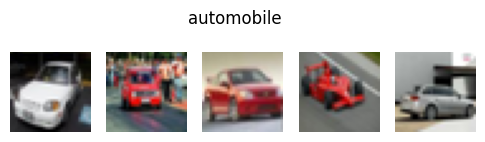

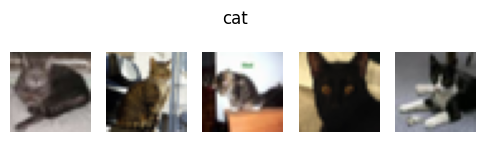

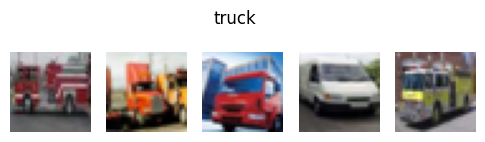

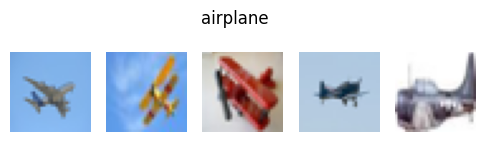

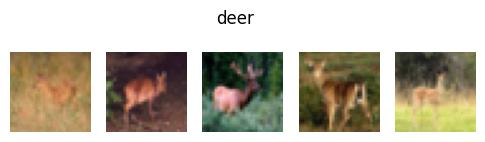

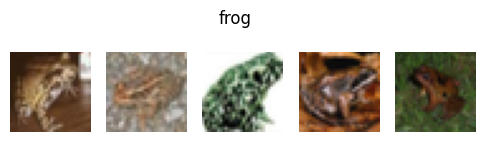

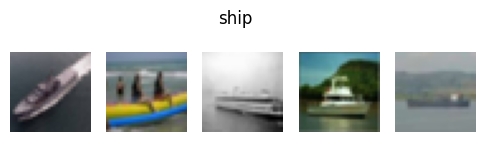

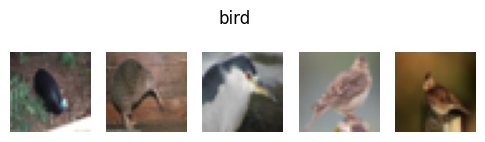

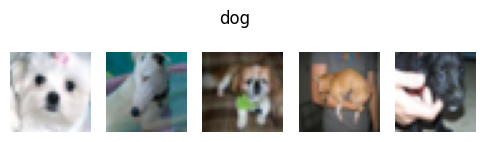

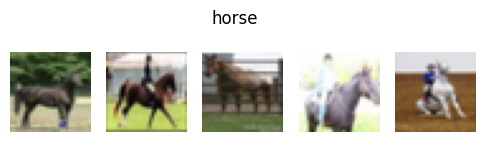

In [12]:
from src.pytorch_modular.visual import explore_train_data
explore_train_data(TRAIN_FOLDER, seed=11)

In [13]:
from src.pytorch_modular.transfer_learning.resnetFeatureExtractor import ResNetFeatureExtractor
default_transform = ResNetFeatureExtractor.default_transform
print(default_transform)

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [14]:
import src.pytorch_modular.transfer_learning.resnetBasedClassifier as resBC
import src.pytorch_modular.image_classification.classification_head as ch
import torchvision.transforms as tr
from torch.optim import AdamW
from torch.optim.lr_scheduler import LinearLR
# since resnet is trained on larger images, using its default transform is likely to hurt performance, as images will be
# significantly hurt performance nevertheless, we can use the normalization values

preprocess = tr.Compose([tr.ToTensor(), tr.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# let's create the dataloaders ourselves
from src.pytorch_modular.data_loaders import create_dataloaders
train_loader, val_loader, classes_info =  create_dataloaders(train_dir=SANITY_CHECK,
                                                             test_dir=VAL_FOLDER,
                                                             train_transform=preprocess,
                                                             test_transform=preprocess,
                                                             batch_size=32
                                                             )

print(classes_info)

# the loss, output layer, training details are shared across the networks built on top of different feature extractors
# nevertheless, the learning rate as well as the scheduler seem to be the only non-common hyper-parameters 4
# that might be suggested differently for each feature extractor

# the learning rates used will be in the vicinity of the values suggested in the paper
lrs = 0.1 # the default value
# since the initial choice of the model will be based on the train loss on the sanity check split   
scheduler_parameters = {'start_factor': 1, 'end_factor': 0.9, 'total_iters': 200}

# let's perform our experiment with a very generic classification head 
generic_classifier = ch.GenericClassifier(2, 2)


{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


In [15]:
optimizer = AdamW
scheduler = LinearLR

train_configuration = {
                    'optimizer': optimizer, 
                    'scheduler': scheduler, 
                    'max_epochs': 5,
                    'report_epoch': 1,
                    }

# create the feature selector
feature_selector = resBC.ResnetFeatureSelector(classifier=generic_classifier)
our_model = feature_selector.select_downstream_model(learning_rates=lrs,
                                                     schedulers_params=scheduler_parameters, 
                                                     train_configuration=train_configuration,
                                                     train_data=train_loader,
                                                     val_data=val_loader,
                                                     num_classes=len(classes_info),
                                                     log_dir=os.path.join(HOME, 'runs')
                                                    )


/home/ayhem18/DEV/My_Kaggle_Repo/kaggle_env/lib/python3.11/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/home/ayhem18/DEV/My_Kaggle_Repo/src/pytorch_modular/transfer_learning/resnetBasedClassifier.py:93: UserWarning: At least One transformation was explicitly set. Transformations are ignoredsince dataloaders were passed as data sources.
  warnings.warn("At least One transformation was explicitly set. Transformations are ignored"


####################################################################################################
training network with option 1 started


[INFO] Created SummaryWriter, saving to: /home/ayhem18/DEV/My_Kaggle_Repo/src/Cifar10/runs/1/resnet_1_block/network_1...


 20%|██        | 1/5 [00:01<00:05,  1.32s/it]

#########################
training loss: 11.142121497222355
train_accuracy: 0.3053571428571429
validation loss : 3.8121473155915737
val_accuracy: 0.42107371794871795
#########################


 40%|████      | 2/5 [00:02<00:03,  1.25s/it]

#########################
training loss: 3.7768144241401127
train_accuracy: 0.39441964285714287
validation loss : 3.343361320403906
val_accuracy: 0.4358974358974359
#########################


 60%|██████    | 3/5 [00:03<00:02,  1.23s/it]

#########################
training loss: 4.016316699981689
train_accuracy: 0.4185267857142857
validation loss : 3.8903009726737556
val_accuracy: 0.3203125
#########################


 80%|████████  | 4/5 [00:04<00:01,  1.23s/it]

#########################
training loss: 5.372038315023695
train_accuracy: 0.39017857142857143
validation loss : 4.853666538993518
val_accuracy: 0.41806891025641024
#########################


100%|██████████| 5/5 [00:06<00:00,  1.25s/it]

#########################
training loss: 4.341297819784709
train_accuracy: 0.43660714285714286
validation loss : 3.371781210295665
val_accuracy: 0.484775641025641
#########################


####################################################################################################
training network with option 1 completed


####################################################################################################
training network with option 2 started


[INFO] Created SummaryWriter, saving to: /home/ayhem18/DEV/My_Kaggle_Repo/src/Cifar10/runs/1/resnet_1_block/1/resnet_2_block/s/network_2...


 20%|██        | 1/5 [00:01<00:06,  1.62s/it]

#########################
training loss: 11.982760173933846
train_accuracy: 0.42745535714285715
validation loss : 4.452553694984183
val_accuracy: 0.5486778846153846
#########################


 40%|████      | 2/5 [00:03<00:04,  1.66s/it]

#########################
training loss: 4.6163524789469585
train_accuracy: 0.5455357142857142
validation loss : 5.384893532669267
val_accuracy: 0.5715144230769231
#########################


 60%|██████    | 3/5 [00:04<00:03,  1.67s/it]

#########################
training loss: 3.8224651830536978
train_accuracy: 0.5988839285714286
validation loss : 6.179345733481795
val_accuracy: 0.522636217948718
#########################


 80%|████████  | 4/5 [00:06<00:01,  1.70s/it]

#########################
training loss: 5.019547101003783
train_accuracy: 0.5973214285714286
validation loss : 7.364338793362156
val_accuracy: 0.5016025641025641
#########################


100%|██████████| 5/5 [00:08<00:00,  1.70s/it]

#########################
training loss: 4.725550878047943
train_accuracy: 0.6042410714285714
validation loss : 9.05641695849884
val_accuracy: 0.5550881410256411
#########################


####################################################################################################
training network with option 2 completed


####################################################################################################
training network with option 3 started


[INFO] Created SummaryWriter, saving to: /home/ayhem18/DEV/My_Kaggle_Repo/src/Cifar10/runs/1/resnet_1_block/1/resnet_2_block/s/1/resnet_3_block/s/network_3...


 20%|██        | 1/5 [00:02<00:09,  2.38s/it]

#########################
training loss: 12.609444270815167
train_accuracy: 0.4642857142857143
validation loss : 14.150056681571863
val_accuracy: 0.5436698717948718
#########################


 40%|████      | 2/5 [00:04<00:06,  2.27s/it]

#########################
training loss: 7.123257784332548
train_accuracy: 0.5564732142857143
validation loss : 13.007218312567625
val_accuracy: 0.5635016025641025
#########################


 60%|██████    | 3/5 [00:06<00:04,  2.22s/it]

#########################
training loss: 7.7266203982489445
train_accuracy: 0.5854910714285714
validation loss : 10.074979662369842
val_accuracy: 0.6127804487179487
#########################


 80%|████████  | 4/5 [00:08<00:02,  2.24s/it]

#########################
training loss: 6.7885492418493545
train_accuracy: 0.6305803571428571
validation loss : 15.433214555757168
val_accuracy: 0.5564903846153846
#########################


100%|██████████| 5/5 [00:11<00:00,  2.23s/it]

#########################
training loss: 7.20255806360926
train_accuracy: 0.6361607142857143
validation loss : 13.003879544712477
val_accuracy: 0.5582932692307693
#########################


####################################################################################################
training network with option 3 completed


####################################################################################################
training network with option 4 started


[INFO] Created SummaryWriter, saving to: /home/ayhem18/DEV/My_Kaggle_Repo/src/Cifar10/runs/1/resnet_1_block/1/resnet_2_block/s/1/resnet_3_block/s/1/resnet_4_block/s/network_4...


 20%|██        | 1/5 [00:02<00:10,  2.59s/it]

#########################
training loss: 16.46150941337858
train_accuracy: 0.24620535714285716
validation loss : 31.407985516083546
val_accuracy: 0.281650641025641
#########################


 40%|████      | 2/5 [00:05<00:07,  2.53s/it]

#########################
training loss: 19.899217632838656
train_accuracy: 0.2877232142857143
validation loss : 33.08722425118471
val_accuracy: 0.2844551282051282
#########################


 60%|██████    | 3/5 [00:07<00:05,  2.52s/it]

#########################
training loss: 19.629063429151262
train_accuracy: 0.31495535714285716
validation loss : 44.60627550956531
val_accuracy: 0.3004807692307692
#########################


 80%|████████  | 4/5 [00:10<00:02,  2.51s/it]

#########################
training loss: 20.201985257012502
train_accuracy: 0.3247767857142857
validation loss : 62.25968563862336
val_accuracy: 0.31069711538461536
#########################


100%|██████████| 5/5 [00:12<00:00,  2.54s/it]

#########################
training loss: 20.125746924536568
train_accuracy: 0.3470982142857143
validation loss : 59.924193920233314
val_accuracy: 0.3078926282051282
#########################


####################################################################################################
training network with option 4 completed
